In [1]:
!pip install -q transformers hdbscan sentence_transformers

import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import hdbscan
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from datetime import datetime


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Парсинг сырых логов HDFS

In [2]:
# Чтение файла с логами
with open('Data/HDFS/HDFS_full.log', 'r', encoding='utf-8') as file:
    log_lines = file.readlines()

data = []  # Список для обработанных данных
skipped_lines = 0  # Счетчик пропущенных строк

for line in tqdm(log_lines):
    # Удаляем лишние пробелы и разбиваем строку на части (первые 5 компонентов + остальное)
    cleaned_line = line.strip()
    parts = cleaned_line.split(maxsplit=5)
    
    # Проверяем, что строка содержит достаточно частей
    if len(parts) < 6:
        skipped_lines += 1
        continue
    
    try:
        # Разделяем последнюю часть на компонент и сообщение (по первому двоеточию)
        last_part = parts[5]
        # component, message = last_part.split(':', maxsplit=1)
        
        # Формируем итоговую запись: первые 5 признаков + компонент + сообщение
        record = parts[:5]  # Первые 5 признаков
        record.append(last_part)  # 6-й признак: сообщение
        
        # Очищаем от пустых строк и добавляем в данные
        cleaned_record = [item for item in record if item]  # Убираем пустые элементы
        
        # Проверяем, что получилось ровно 7 признаков
        if len(cleaned_record) == 6:
            data.append(cleaned_record)
        else:
            skipped_lines += 1
            
    except ValueError:
        # Если не удалось разделить по двоеточию
        skipped_lines += 1
        continue

print(f'Количество строк с пропусками: {skipped_lines}')

100%|███████████████████████████| 11167740/11167740 [00:47<00:00, 233842.13it/s]

Количество строк с пропусками: 0


In [3]:
columns = ['date_str', 'time_str', 'milliseconds', 'log_level', 'component', 'message']
df = pd.DataFrame(data, columns=columns)

In [4]:
df

,date_str,time_str,milliseconds,log_level,component,message
0,081109,203518,143,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
1,081109,203518,35,INFO,dfs.FSNamesystem:,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...
2,081109,203519,143,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
3,081109,203519,145,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
4,081109,203519,145,INFO,dfs.DataNode$PacketResponder:,PacketResponder 1 for block blk_-1608999687919...
...,...,...,...,...,...,...
11167735,081111,111557,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_-61713680325832...
11167736,081111,111607,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_619502527611431...
11167737,081111,111613,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_-33397734047143...
11167738,081111,111615,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_103723194550928...


In [5]:
# преобразование дат и времени
def parse_datetime_simple(date_str, time_str, milliseconds):
    try:
        # Простой подход без миллисекунд
        datetime_str = f"{date_str} {time_str}"
        return datetime.strptime(datetime_str, '%m%d%y %H%M%S')
    except Exception as e:
        return pd.NaT

# Пробуем оба подхода
print("\nПробуем преобразование дат...")

# Сначала простой подход
tqdm.pandas(desc="Преобразование дат")  # Активируем tqdm для pandas
df['timestamp'] = df.progress_apply(
    lambda row: parse_datetime_simple(row['date_str'], row['time_str'], row['milliseconds']), 
    axis=1
)

valid_count = df['timestamp'].notna().sum()
print(f"Успешно преобразовано дат (простой метод): {valid_count}/{len(df)}")


Пробуем преобразование дат...


Преобразование дат: 100%|████████| 11167740/11167740 [07:34<00:00, 24576.53it/s]

Успешно преобразовано дат (простой метод): 11167740/11167740


In [6]:
# Переупорядочиваем колонки для лучшей читаемости
df['hour'] = df['timestamp'].dt.hour
column_order = [
    'timestamp', 'hour', 'date_str', 'time_str', 'milliseconds', 
    'log_level', 'component', 'message'
]
df = df[column_order].drop(['date_str', 'time_str'], axis=1)
df

,timestamp,hour,milliseconds,log_level,component,message
0,2009-08-11 20:35:18,20,143,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
1,2009-08-11 20:35:18,20,35,INFO,dfs.FSNamesystem:,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...
2,2009-08-11 20:35:19,20,143,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
3,2009-08-11 20:35:19,20,145,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-1608999687919862906 src: ...
4,2009-08-11 20:35:19,20,145,INFO,dfs.DataNode$PacketResponder:,PacketResponder 1 for block blk_-1608999687919...
...,...,...,...,...,...,...
11167735,2011-08-11 11:15:57,11,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_-61713680325832...
11167736,2011-08-11 11:16:07,11,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_619502527611431...
11167737,2011-08-11 11:16:13,11,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_-33397734047143...
11167738,2011-08-11 11:16:15,11,13,INFO,dfs.DataBlockScanner:,Verification succeeded for blk_103723194550928...


## Статистика логов по дате и времени

In [7]:
# Анализ временных характеристик
print(f"\nВременной диапазон логов:")
print(f"Начало: {df['timestamp'].min()}")
print(f"Конец:  {df['timestamp'].max()}")
print(f"Длительность: {df['timestamp'].max() - df['timestamp'].min()}")

# Статистика по сообщениям
print(f"\nТоп-10 самых частых сообщений:")
top_messages = df['message'].str.slice(0, 50).value_counts().head(10)
for message, count in top_messages.items():
    print(f"{count:4d} | {message}...")


Временной диапазон логов:
Начало: 2009-08-11 20:35:18
Конец:  2011-08-11 11:16:28
Длительность: 729 days 14:41:10

Топ-10 самых частых сообщений:
1719741 | BLOCK* NameSystem.addStoredBlock: blockMap updated...
217766 | BLOCK* NameSystem.allocateBlock: /user/root/randtx...
72482 | BLOCK* NameSystem.allocateBlock: /user/root/rand/_...
66918 | BLOCK* NameSystem.allocateBlock: /user/root/sortra...
36361 | BLOCK* NameSystem.allocateBlock: /user/root/rand6/...
36250 | BLOCK* NameSystem.allocateBlock: /user/root/rand4/...
36119 | BLOCK* NameSystem.allocateBlock: /user/root/rand3/...
36094 | BLOCK* NameSystem.allocateBlock: /user/root/rand5/...
35902 | BLOCK* NameSystem.allocateBlock: /user/root/rand7/...
35818 | BLOCK* NameSystem.allocateBlock: /user/root/rand8/...


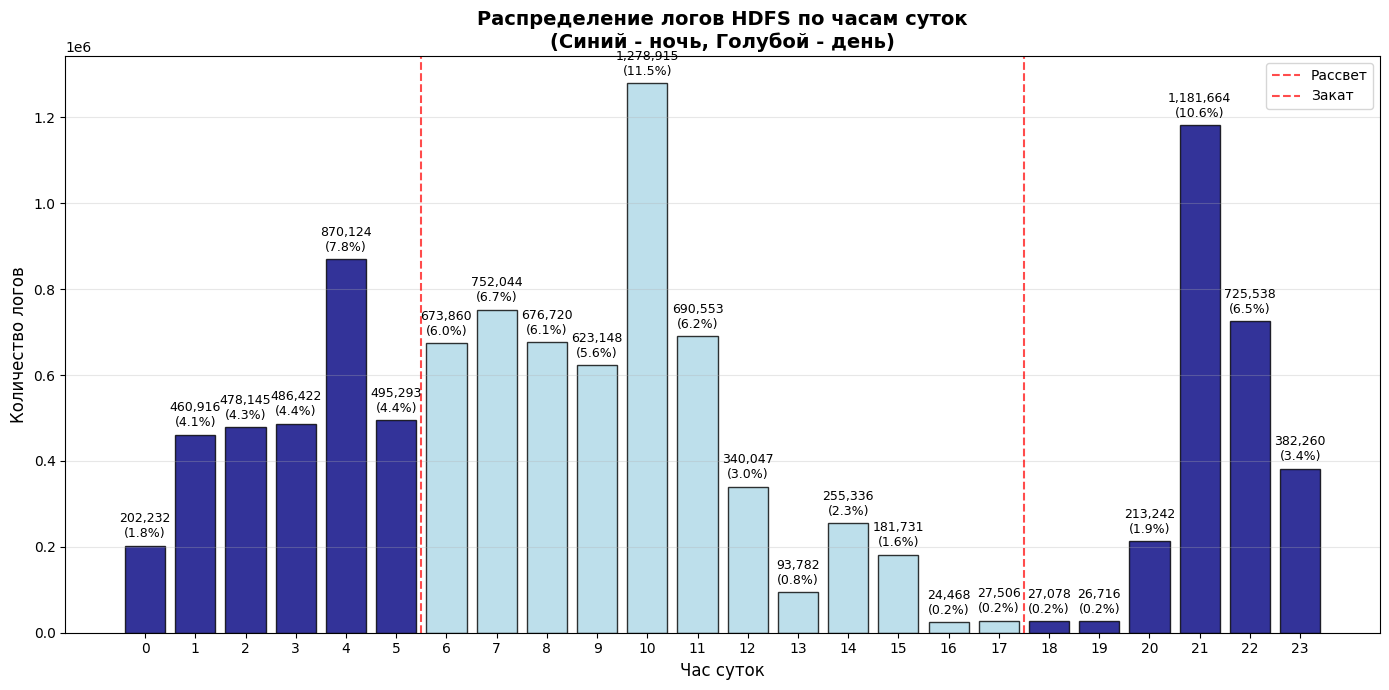

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем данные
hour_distribution = df['hour'].value_counts().sort_index()

# Создаем график с разными цветами для дня и ночи
plt.figure(figsize=(14, 7))

# Определяем цвета: день - теплые цвета, ночь - холодные
colors = ['lightblue' if 6 <= hour < 18 else 'navy' for hour in hour_distribution.index]

bars = plt.bar(hour_distribution.index, hour_distribution.values, 
               color=colors, edgecolor='black', alpha=0.8)

# Настройки графика
plt.title('Распределение логов HDFS по часам суток\n(Синий - ночь, Голубой - день)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество логов', fontsize=12)
plt.xticks(range(0, 24))

# Добавляем значения и проценты
total_logs = hour_distribution.sum()
for i, value in enumerate(hour_distribution.values):
    percentage = (value / total_logs) * 100
    plt.text(hour_distribution.index[i], value + max(hour_distribution.values)*0.01, 
             f'{value:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

# Добавляем разделители дня и ночи
plt.axvline(x=5.5, color='red', linestyle='--', alpha=0.7, label='Рассвет')
plt.axvline(x=17.5, color='red', linestyle='--', alpha=0.7, label='Закат')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Получение эмбедингов + PCA + HDBSCAN

In [9]:
df['log_level'].value_counts()

log_level
INFO    10805922
WARN      361818
Name: count, dtype: int64

In [10]:
N = 10000
RANDOM_ST = 777

df_100_info = df[df['log_level'] == 'INFO'].sample(n = N, random_state=RANDOM_ST)
df_100_warn = df[df['log_level'] == 'WARN'].sample(n = N, random_state=RANDOM_ST)

df_for_cluster = pd.concat([df_100_info, df_100_warn])

df_for_cluster

,timestamp,hour,milliseconds,log_level,component,message
9388854,2011-08-11 08:06:49,8,24154,INFO,dfs.DataNode$PacketResponder:,Received block blk_6936412528606193258 of size...
9154174,2011-08-11 07:56:27,7,28,INFO,dfs.FSNamesystem:,BLOCK* NameSystem.delete: blk_1530134941082480...
10882376,2011-08-11 10:52:52,10,27165,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_2348598485033006978 src: /...
1114179,2010-08-11 01:09:38,1,4972,INFO,dfs.DataNode$PacketResponder:,PacketResponder 0 for block blk_-3364717277340...
10194052,2011-08-11 09:23:57,9,25489,INFO,dfs.DataNode$DataXceiver:,Receiving block blk_-8923578592298151540 src: ...
...,...,...,...,...,...,...
3602730,2010-08-11 13:33:20,13,11554,WARN,dfs.DataNode$DataXceiver:,10.251.202.134:50010:Got exception while servi...
3551659,2010-08-11 13:01:04,13,11329,WARN,dfs.DataNode$DataXceiver:,10.251.109.236:50010:Got exception while servi...
5808433,2010-08-11 23:55:13,23,17133,WARN,dfs.DataNode$DataXceiver:,10.251.71.16:50010:Got exception while serving...
496245,2009-08-11 21:44:16,21,2653,WARN,dfs.DataNode$DataXceiver:,10.250.10.213:50010:Got exception while servin...


In [11]:
from torch.utils.data import Dataset, DataLoader

# Настройки модели
model_name = "bert-base-multilingual-cased"  
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Кастомный Dataset
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts.reset_index(drop=True)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return str(self.texts[idx])

# Функция для обработки батчей 
def get_batch_embeddings(texts_batch):
    """Получает эмбеддинги для батча текстов используя вашу логику"""
    try:
        # Токенизация батча 
        inputs = tokenizer(
            texts_batch.tolist() if isinstance(texts_batch, pd.Series) else texts_batch,
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        )
        inputs = inputs.to(device)
        
        # Получение эмбеддингов 
        with torch.no_grad():
            outputs = model(**inputs)
            # Используем [CLS] токен как у вас
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        return embeddings
    except Exception as e:
        print(f"Ошибка при обработке батча: {e}")
        # Возвращаем нулевые эмбеддинги в случае ошибки
        return np.zeros((len(texts_batch), model.config.hidden_size))

# Основная функция
def get_embeddings_batch(df, text_column='message', batch_size=32):
    """
    Получает эмбеддинги для всего DataFrame батчами
    """
    print(f"Используется устройство: {device}")
    print(f"Размер эмбедингов: {model.config.hidden_size} features")
    
    # Создаем DataLoader
    dataset = TextDataset(df[text_column])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Собираем все эмбеддинги
    all_embeddings = []
    
    with tqdm(total=len(dataloader), desc="Получение эмбеддингов") as pbar:
        for batch_texts in dataloader:
            batch_embeddings = get_batch_embeddings(batch_texts)
            all_embeddings.append(batch_embeddings)
            pbar.update(1)
    
    # Объединяем все эмбеддинги
    all_embeddings = np.vstack(all_embeddings)
    
    # Создаем DataFrame с эмбеддингами
    embedding_columns = [f'embed_{i}' for i in range(all_embeddings.shape[1])]
    embeddings_df = pd.DataFrame(all_embeddings, columns=embedding_columns)
    
    # Сохраняем исходные данные и индексы
    # embeddings_df['original_message'] = df[text_column].values
    embeddings_df.index = df.index
    
    return embeddings_df

embeddings_df = get_embeddings_batch(df_for_cluster, batch_size=64)
print(f"Размерность эмбеддингов: {embeddings_df.shape}")
embeddings_df.head()

Используется устройство: cuda
Размер эмбедингов: 768 features


Получение эмбеддингов: 100%|██████████████████| 313/313 [00:26<00:00, 11.79it/s]


Размерность эмбеддингов: (20000, 768)


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
9388854,0.091926,-0.292965,0.045412,-0.071467,0.200828,0.318207,0.231218,-0.168192,0.035200,-0.148279,...,0.342889,-0.222018,-0.430213,-0.208708,0.185891,0.426181,0.348503,0.491518,0.293183,-0.119071
9154174,0.513605,-0.521474,-0.143688,0.028572,0.261410,0.249488,-0.094174,-0.250917,0.103361,-0.495590,...,0.424755,-0.184924,-0.629031,-0.245720,0.029791,0.470005,0.108814,0.749215,0.250293,-0.111600
10882376,0.052164,-0.299255,-0.038086,0.154880,0.199282,0.234699,0.156764,-0.125543,-0.034876,-0.139643,...,0.286658,-0.166391,-0.546559,-0.455742,0.291926,0.368758,0.139138,0.520996,0.142836,0.087453
1114179,0.487531,-0.350919,-0.051643,0.100309,0.273210,0.058040,-0.094183,-0.304117,-0.195840,-0.110324,...,0.215289,-0.252888,-0.304331,-0.844913,0.190299,0.427409,0.121596,0.597703,0.210553,-0.091601
10194052,0.085562,-0.281524,-0.046275,0.136887,0.213914,0.196808,0.109349,-0.137592,-0.083896,-0.132393,...,0.247334,-0.116261,-0.572289,-0.509301,0.372013,0.254822,0.093100,0.584036,0.132725,0.088852


In [12]:
embeddings_df.to_parquet('embeddings_df.parquet')

In [13]:
import gc

del data
del df
gc.collect()
torch.cuda.empty_cache()

In [14]:
%%time

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings_df)

CPU times: user 182 ms, sys: 30.1 ms, total: 212 ms
Wall time: 211 ms


In [18]:
embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 9388854 to 1693364
Columns: 768 entries, embed_0 to embed_767
dtypes: float32(768)
memory usage: 58.7 MB


In [19]:
%%time

from sklearn.decomposition import IncrementalPCA

# Конвертируем в numpy array для ускорения
X = embeddings_df.values.astype(np.float32)
print(f"Размер данных: {X.shape}")

# Используем IncrementalPCA с батчами
n_components = 100
batch_size = 1000
ipca = IncrementalPCA(n_components=n_components)

# Обучаем по батчам с прогресс-баром
n_batches = (X.shape[0] + batch_size - 1) // batch_size

print("Обучение PCA по батчам...")
for i in tqdm(range(n_batches), desc="Batch processing"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X.shape[0])
    batch = X[start_idx:end_idx]
    ipca.partial_fit(batch)

# Применяем преобразование по батчам
X_pca = np.zeros((X.shape[0], n_components), dtype=np.float32)

print("Применение PCA преобразования...")
for i in tqdm(range(n_batches), desc="Transforming"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X.shape[0])
    batch = X[start_idx:end_idx]
    X_pca[start_idx:end_idx] = ipca.transform(batch)

print(f"Размер после PCA: {X_pca.shape}")

Размер данных: (20000, 768)
Обучение PCA по батчам...


Batch processing: 100%|█████████████████████████| 20/20 [00:09<00:00,  2.01it/s]


Применение PCA преобразования...


Transforming: 100%|█████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Размер после PCA: (20000, 100)
CPU times: user 1min 53s, sys: 1.43 s, total: 1min 54s
Wall time: 10.2 s


In [20]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=16, 
    min_samples = 4,
    gen_min_span_tree=False,
    algorithm='best',
)

clusters = clusterer.fit_predict(X_pca)

hdbscan_anomalies = np.sum(clusters == -1)
print(f"Образцов не вошло в кластеры (аномалии HDBSCAN): {hdbscan_anomalies}")

Образцов не вошло в кластеры (аномалии HDBSCAN): 35


In [21]:
clusters

array([8, 1, 9, ..., 2, 2, 2])